In [1]:
import junodch_utils_read_img as utils

import matplotlib.pyplot as matPlt
import numpy as np
import tensorflow as tf
from tqdm.keras import TqdmCallback

import keras
from keras import layers
import rasterio

# Data preparation
### Fetch data from file

In [2]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
#pathNight = folderName + "Night VIIRS_1.tif"
pathNight = folderName + "lowres_night_1.tif"
pathValidation = folderName + "Population GHSL_1.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, validThreshold=1, area=aoi)

trainMask = dataRadiance>25
lightCoords = dataCoords[trainMask]

print('Tiles:',dataCoords.shape[0])
print('Light Tile:',lightCoords.shape[0])

Tiles: 137868
Light Tile: 894


In [3]:
'''
trainMask2 = [
  2,3,10,11,12,14,15,16,17,18,19,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,43,44,45,46,48,49,50,
  51,52,53,55,56,57,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,
  101,102,103,104,105,106,107,108,109,110,111,112,113,114,117,118,119,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,140,141,142,143,144,145,146,147,148,149,
  150,151,152,153,154,155,156,157,158,159,160,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,
  200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,239,240,241,242,243,244,245,246,247,248,249,
  250,251,252,253,254,255,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,295,296,297,298,299,
  300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,323,324,325,326,327,328,329,330,331,332,333,334,335,338,339,340,342,343,344,345,347,348,349,
  350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,386,387,388,389,390,391,392,393,395,396,397,398,399,
  400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,439,440,441,442,443,444,446,447,448,449,
  450,451,452,455,456,457,458,459,460,461,471,472,473,474,475,476,477,478,487,488,489,490,491,492,493,494,495,
  503,504,505,506,507,508,509,510,511,512,513,514,515,519,520,521,522,523,524,525,526,527,528,529,530,531,535,536,537,538,539,540,541,542,544,545,546,547,548,549,
  550,553,554,555,556,560,561,563,564,565,566,567,571,572,573,574,575,576,577,578,579,580,581,582,583,586,587,588,589,590,592,593,594,595,597,598,599,
  600,601,602,603
]
'''

# Fetch images
with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.getEachImgFromCoord(f, dataCoords[trainMask], True)
trainData = utils.formatData(trainData, res=64, toFloat=True)
print(trainData.shape)

(894, 64, 64, 3)


# Autoencoder

In [18]:
# Input encoder
input_shape = keras.Input(shape=trainData.shape[1:])

#optimizer = 'adam'
optimizer = keras.optimizers.Adam(
  learning_rate=0.0015,
  beta_1=0.9,
  beta_2=0.999,
)

#lossFunction = keras.losses.MeanAbsoluteError() # L1
lossFunction = keras.losses.MeanSquaredError() # l2
#lossFunction = keras.losses.MeanSquaredLogarithmicError()

activationFunction = 'relu'
#activationFunction = lambda x: tf.keras.activations.relu(x, max_value=255)

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=3)

class Sampling(layers.Layer):
  def call(self, inputs):
    mu, log_variance = inputs
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    return mu + tf.keras.backend.exp(log_variance/2) * epsilon

latent_space_dim = 8*8*16

cnn = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(input_shape)
cnn = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(cnn)
encoded = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction, name='encoder')(cnn)

shape_before_flatten = keras.backend.int_shape(encoded)[1:]

cnn = layers.Flatten()(encoded)
encoder_mu = layers.Flatten()(encoded)


cnn = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(input_shape)
cnn = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(cnn)
encoded = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(cnn)
encoder_logvar = layers.Flatten()(encoded)
#encoder_mu = layers.Dense(units=latent_space_dim, name="encoder_mu")(cnn)
#encoder_logvar = layers.Dense(units=latent_space_dim, name="encoder_log_variance")(cnn)

encoder_output = Sampling()([encoder_mu, encoder_logvar])

decoder_dense_layer = layers.Dense(np.prod(shape_before_flatten), name="decoder_dense")(encoder_output)
decoder_reshape = layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer)

cnn = layers.Conv2DTranspose(16,(3,3),2, padding='same', activation=activationFunction)(decoder_reshape)
#cnn = layers.UpSampling2D((2,2))(cnn)
cnn = layers.Conv2DTranspose(16,(3,3),2, padding='same', activation=activationFunction)(cnn)
#cnn = layers.UpSampling2D((2,2))(cnn)
decoder = layers.Conv2DTranspose(3, (3,3),2, padding='same', activation='sigmoid', name='decoder')(cnn)

autoencoder = keras.Model(input_shape, decoder)
autoencoder.compile(optimizer=optimizer, loss=lossFunction)

print('Encoder shape:',autoencoder.get_layer('encoder').output_shape)
autoencoder.get_output_shape_at
result = autoencoder.fit(trainData, trainData,
                          epochs=50,
                          batch_size=2,
                          shuffle=True,
                          verbose=0,
                          callbacks=[
                            TqdmCallback(verbose=1), # Concise display progression
                            earlyStop,
                          ],
                        )


Encoder shape: (None, 8, 8, 16)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_31 (Conv2D)             (None, 32, 32, 16)   448         ['input_9[0][0]']                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 32, 32, 16)   448         ['input_9[0][0]']                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 16, 16, 16)   2320        ['conv2d_31[0][0]']              
                                                                                            

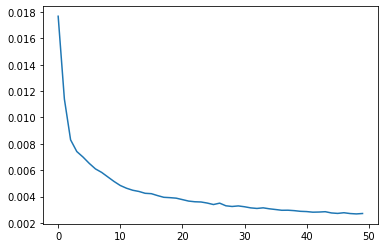

In [19]:
matPlt.plot(result.history['loss'][:], label='Training')
autoencoder.summary()

Test display some tiles
Original data: (40, 64, 64, 3)


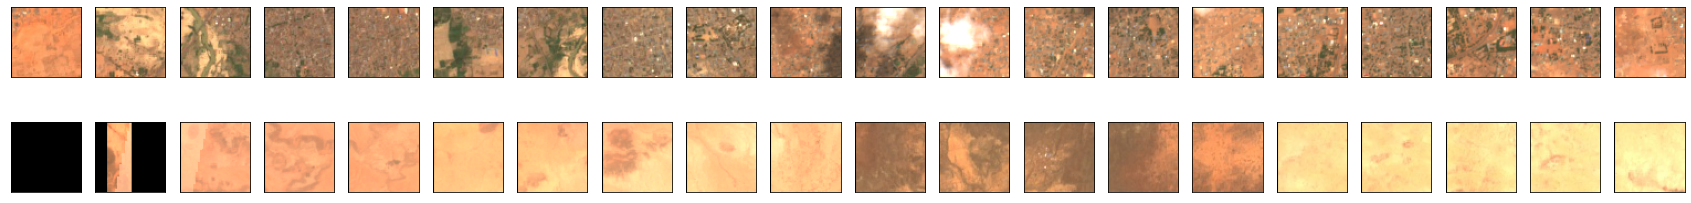

2/2 [==============================] - 1s 16ms/step
Output data: (40, 64, 64, 3)


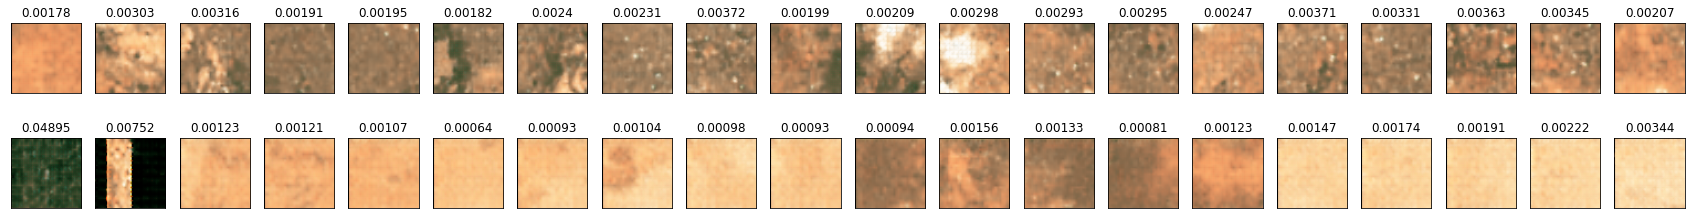

In [20]:
print("Test display some tiles")

indexesTest = [*np.argwhere(trainMask)[-20:].flatten(), *range(0,1), *range(1104,1108), *range(1118,1123), *range(4005,4010), *range(10005,10010)]

with rasterio.open(pathSatellite) as f:
  dataTest, _ = utils.getEachImgFromCoord(f, dataCoords[indexesTest], True)
dataTest = utils.formatData(dataTest, res=64, toFloat=True)

utils.displayAutoEncoderResults(autoencoder, dataTest, showDetail=0, precision=5)

In [ ]:
autoencoder.save('model/autoencoder_64_GEN7_V2')